# Ajustes iniciales

## Conexión a drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#  !!!! ES NECESARIO EDITAR CON EL PATH CORRESPONDIENTE  !!!!
%cd drive/MyDrive/'Colab Notebooks/TTT-2020-1-16'

/content/drive/MyDrive/Colab Notebooks/TTT-2020-1-16


In [3]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/TTT-2020-1-16'

## Importar los módulos *_utils

In [4]:
import sys
#  !!!! ES NECESARIO EDITAR CON EL PATH CORRESPONDIENTE  !!!!
sys.path.append('/content/drive/My Drive/Colab Notebooks/TTT-2020-1-16')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

In [5]:
import pickle

# Funciones locales

## Prototipo de modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,SpatialDropout1D
from tensorflow import keras
from tensorflow.keras import layers

def convolutionalNetModel(task, params, optimizer, verbose = False):
  """
  Defines and compiles a new Keras model for a Convolutional Neural Network

  """

  SEQ_LENGTH = 55
  VEC_EMBEDDINGS_DIM = 300

  kernel_size_1, kernel_size_2, kernel_size_3 = params['kernels_combos']
  cnn_activation = params['conv_layers_activation']
  n_filters = params['n_filters']
  DL_1, DL_2 = params['dense_layers_sizes']
  spatial_dropout = params['spatial_dropout']
  dense_dropout = params['dense_dropout']

  embedding_sequences_input = keras.Input(name='INPUT', shape=(SEQ_LENGTH, VEC_EMBEDDINGS_DIM), dtype="float64")

  cnn_1 = layers.Conv1D(n_filters, kernel_size_1, activation=cnn_activation, name = 'CNN1')(embedding_sequences_input)
  cnn_1 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_1')(cnn_1)
  
  cnn_2 = layers.Conv1D(n_filters, kernel_size_2, activation=cnn_activation, name = 'CNN2')(embedding_sequences_input)
  cnn_2 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_2')(cnn_2)
  
  cnn_3 = layers.Conv1D(n_filters, kernel_size_3, activation=cnn_activation, name = 'CNN3')(embedding_sequences_input)
  cnn_3 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_3')(cnn_3)

  if params['pooling_method'] == 'max':
    cnn_1 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_1')(cnn_1)
    cnn_2 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_2')(cnn_2)
    cnn_3 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_3')(cnn_3)
  elif params['pooling_method'] == 'average':
    cnn_1 = layers.GlobalAveragePooling1D(name = 'MAX_POOL_1')(cnn_1)
    cnn_2 = layers.GlobalAveragePooling1D(name = 'MAX_POOL_2')(cnn_2)
    cnn_3 = layers.GlobalAveragePooling1D(name = 'MAX_POOL_3')(cnn_3)

  fcnn = layers.Concatenate(axis=1, name = 'CONCATENATE')([cnn_1, cnn_2, cnn_3])
  fcnn = layers.Dense(DL_1, activation="relu", name = 'DL_1')(fcnn)
  fcnn = layers.Dropout(dense_dropout, name = 'DENSE_DROP_1')(fcnn)
  fcnn = layers.Dense(DL_2, activation="relu", name = 'DL_2')(fcnn)
  fcnn = layers.Dropout(dense_dropout, name = 'DENSE_DROP_2')(fcnn)

  if task in ['HS', 'TR', 'AG']:
    preds = layers.Dense(1, activation="sigmoid", name = 'PREDICTOR')(fcnn)
    model = keras.Model(embedding_sequences_input, preds)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

  elif task == 'HTA':
    preds = layers.Dense(5, activation="softmax", name = 'PREDICTOR')(fcnn)
    preds = reshape = layers.Reshape(target_shape=(5,))(preds)

    model = keras.Model(embedding_sequences_input, preds)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

  if verbose:
    model.summary()

  return model

# Experimentos con optimizadores

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['AG'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[100,150,200],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

12 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


6 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


72 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/HS_experiments_1.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/CNN/HTA_experiments_1_batch_1.df
SCANNING SEARCH SPACE

36 configurations will be evaluated.
1  - conf_ID: xbdqfQrF   ****  --  train_acc_A = 0.813,  val_acc_A = 0.742    --  train_acc_B = 0.721,  val_acc_B = 0.757   
2  - conf_ID: VjevGVyM   

## Resultados

In [7]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/AG/experiments_1.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head()

In [ ]:
params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 
                            'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4']}

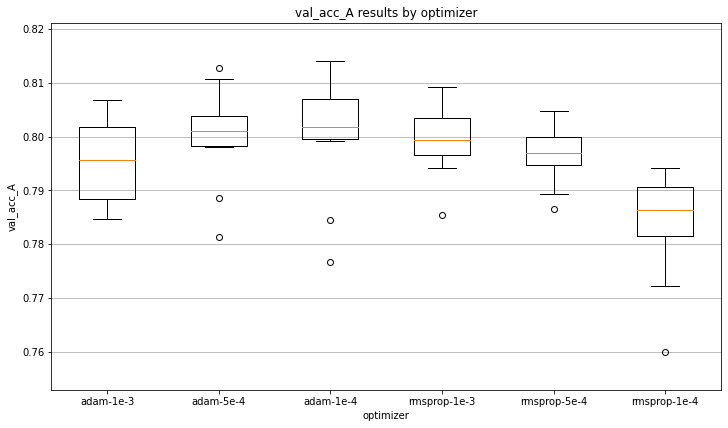

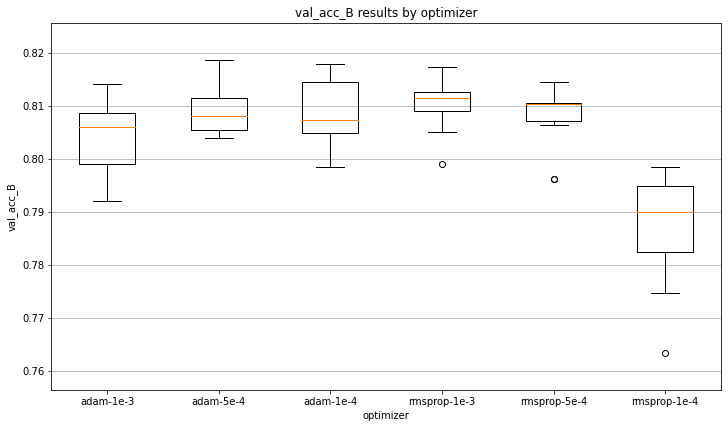

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


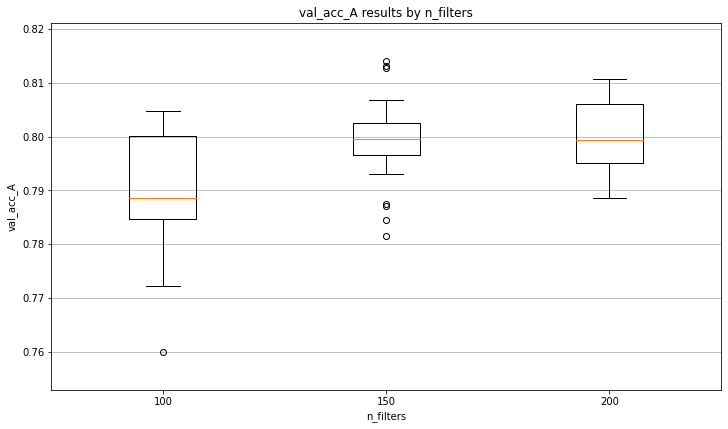

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


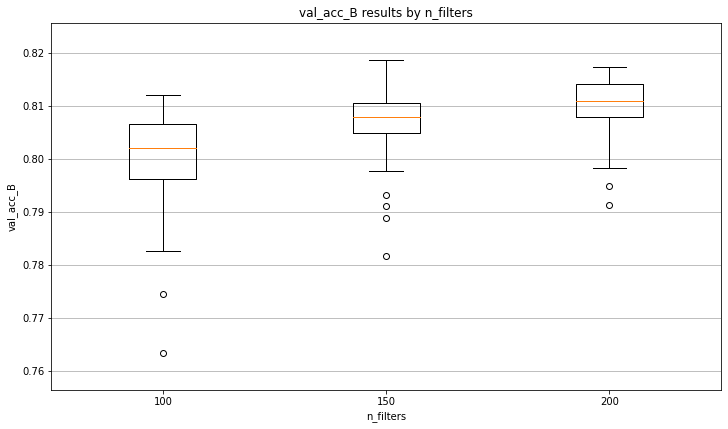

In [ ]:
params_dict = {'n_filters':[100,150,200]}

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'

# Experimentos con el tamaño de las capas densas

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['AG'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[150,200],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

24 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/AG/experiments_2.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [8]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/AG/experiments_2.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(48, 19)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head()

In [ ]:
params_dict = {'dense_layers_sizes':[(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)]}

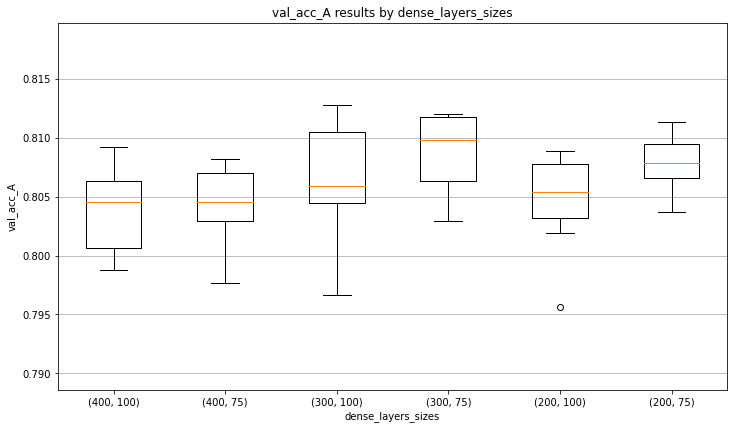

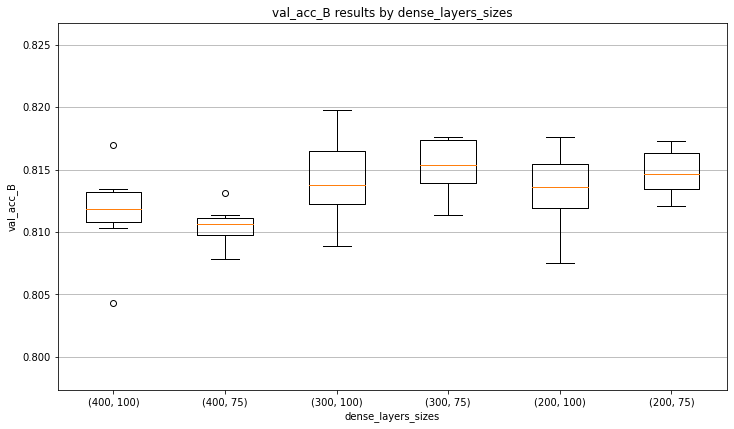

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [(300,100),**(200,75)**], [**(400,75)**,(200,100)]
* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'

# Experimentos con los valores de dropout

## Dataset

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(300,100),
                      (300,75)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.3,0.5,0.7],
              'dense_dropout':[0.3,0.5,0.7]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

36 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


72 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          convolutionalNetModel, 
                          search_space[50:],
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/AG/experiments_3_2.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/CNN/AG/experiments_3_2.df
SCANNING SEARCH SPACE

22 configurations will be evaluated.
1  - conf_ID: brzozlZS   ****  --  train_acc_1 = 0.881,  val_acc_1 = 0.802    --  train_acc_2 = 0.795,  val_acc_2 = 0.809   
2  - conf_ID: FcwiOGcI   ****  --  train_acc_1 = 0.795,  val_acc_1 = 0.808    --  train_acc_2 = 0.809,  val_acc_2 = 0.812   
3  - conf_ID: eMemQfKA   ****  --  train_acc_1 = 0.794,  val_acc_1 = 0.8      --  train_acc_2 = 0.776,  val_acc_2 = 0.805   
4  - conf_ID: wuiAdNlf   ****  --  train_acc_1 = 0.787,  val_acc_1 = 0.804    --  train_acc_2 = 0.788,  val_acc_2 = 0.81    
5  - conf_ID: NDkibrUG   ****  --  train_acc_1 = 0.821,  val_acc_1 = 0.804    --  train_acc_2 = 0.861,  val_acc_2 = 0.81    
6  - conf_ID: JZEtIaWQ   ****  --  train_acc_1 = 0.808,  val_acc_1 = 0.8      --  train_acc_2 = 0.812,  val_acc_2 = 0.812   
7  - conf_ID: sAnXHboV   ****  --  train_acc_1 = 0.811,  val_acc_1 = 0.812    --  train_acc_2 = 0.819,  val_acc_2 = 0.817   
8  - conf_ID: ljt

## Resultados

In [9]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/AG/experiments_3.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(92, 19)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

In [ ]:
params_dict = {'spatial_dropout':[0.3,0.5,0.7]}

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


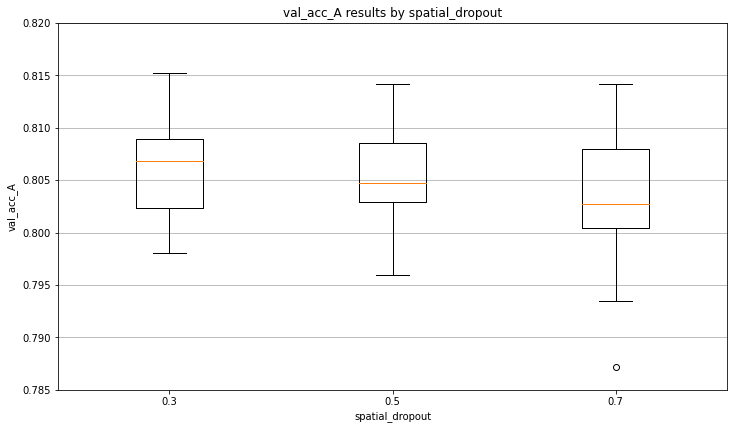

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


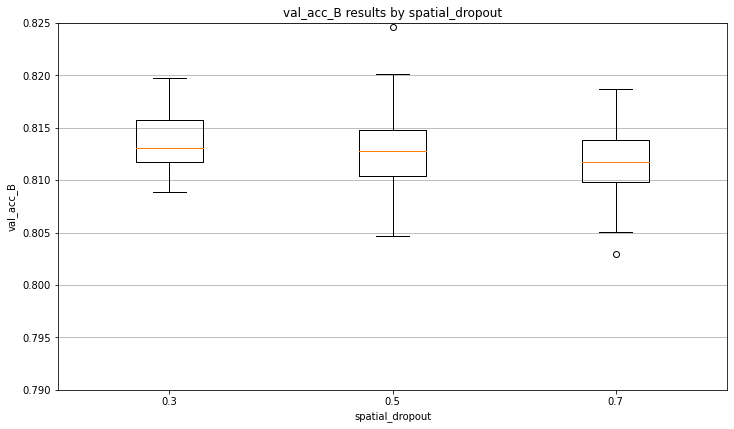

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_A',
                       y_limits=[0.785,0.82])

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_B',
                       y_limits=[0.79,0.825])

In [ ]:
params_dict = {'dense_dropout':[0.3,0.5,0.7]}
spatial_dropout_mask = search_results['spatial_dropout'] == 0.3

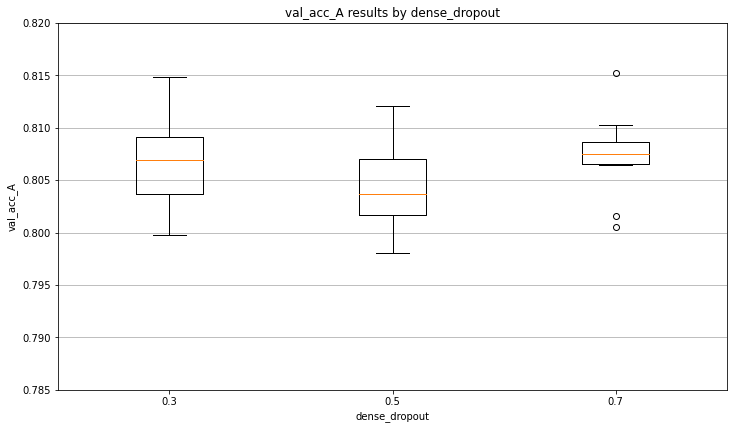

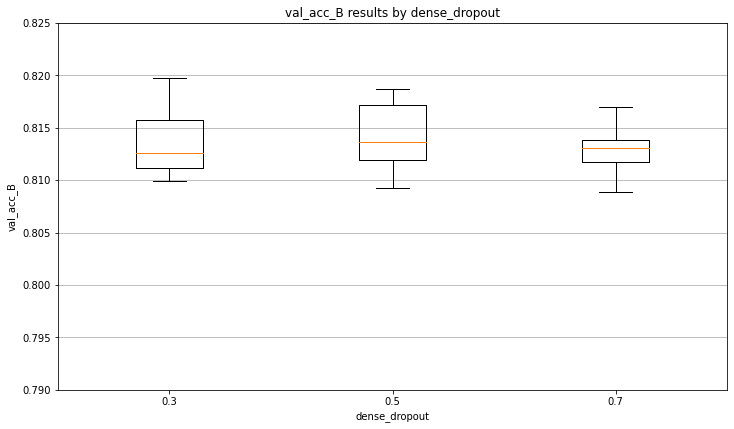

In [ ]:
results_utils.plotResultsByParameter1(search_results.loc[spatial_dropout_mask], 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_A',
                       y_limits=[0.785,0.82])

results_utils.plotResultsByParameter1(search_results.loc[spatial_dropout_mask], 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_B',
                       y_limits=[0.79,0.825])

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [(300,100),**(200,75)**], [**(400,75)**,(200,100)]
* spatial_dropout: [0.3,**0.5**]
* dense_dropout:[**0.5**]


* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'


# Experimentos con la función de activación y pooling method

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['AG'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import combinations
from itertools import product

dense_layers_sizes = [(300,100),
                      (300,75)]                                 

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175],
              'conv_layers_activation':['tanh','relu'],
              'pooling_method':['max', 'average'],
              'spatial_dropout':[0.3],
              'dense_dropout':[0.3]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))     

16 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


32 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/AG/experiments_4.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/CNN/AG/experiments_4.df
SCANNING SEARCH SPACE

32 configurations will be evaluated.
1  - conf_ID: drKINfrh   ****  --  train_acc_1 = 0.819,  val_acc_1 = 0.804    --  train_acc_2 = 0.815,  val_acc_2 = 0.81    
2  - conf_ID: fbBlnHai   ****  --  train_acc_1 = 0.789,  val_acc_1 = 0.805    --  train_acc_2 = 0.807,  val_acc_2 = 0.816   
3  - conf_ID: MuDxNrAq   ****  --  train_acc_1 = 0.773,  val_acc_1 = 0.788    --  train_acc_2 = 0.766,  val_acc_2 = 0.794   
4  - conf_ID: BUHfiAVO   ****  --  train_acc_1 = 0.798,  val_acc_1 = 0.784    --  train_acc_2 = 0.777,  val_acc_2 = 0.793   
5  - conf_ID: RUmPztTx   ****  --  train_acc_1 = 0.837,  val_acc_1 = 0.808    --  train_acc_2 = 0.824,  val_acc_2 = 0.812   
6  - conf_ID: gJVGoERh   ****  --  train_acc_1 = 0.988,  val_acc_1 = 0.797    --  train_acc_2 = 0.813,  val_acc_2 = 0.817   
7  - conf_ID: brUJrPKA   ****  --  train_acc_1 = 0.808,  val_acc_1 = 0.805    --  train_acc_2 = 0.814,  val_acc_2 = 0.809   
8  - conf_ID: pfNEv

## Resultados

In [10]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/AG/experiments_4.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(32, 19)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

In [ ]:
params_dict = {'conv_layers_activation':['tanh', 'relu']}

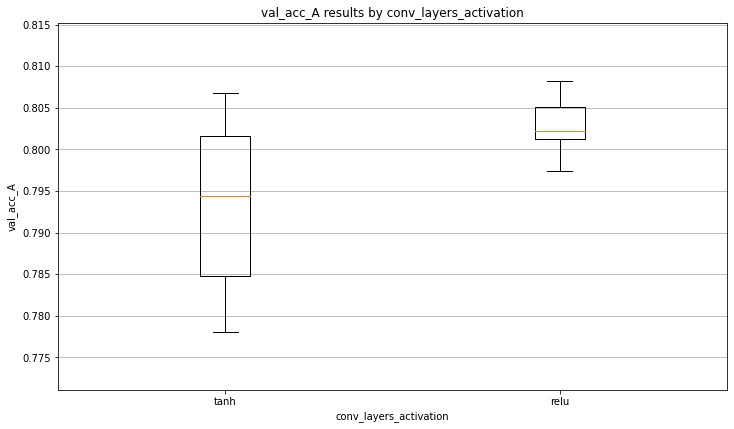

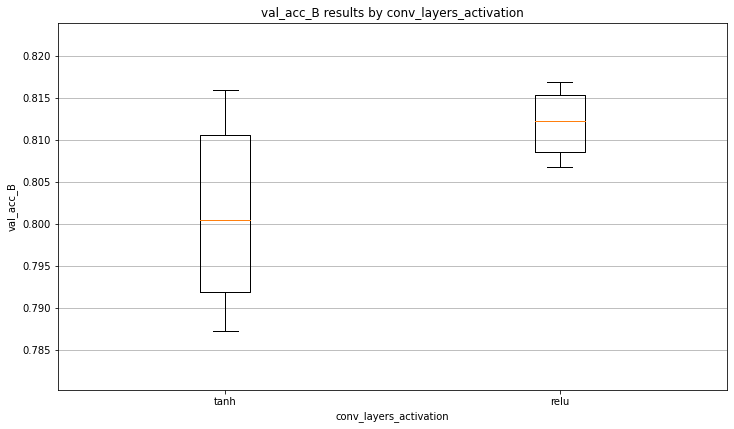

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['conv_layers_activation'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['conv_layers_activation'],
                       metric='val_acc_B')

In [ ]:
params_dict = {'pooling_method':['max', 'average']}

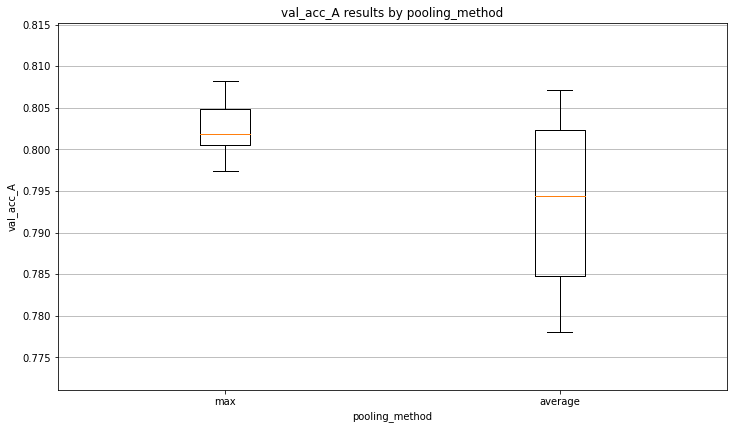

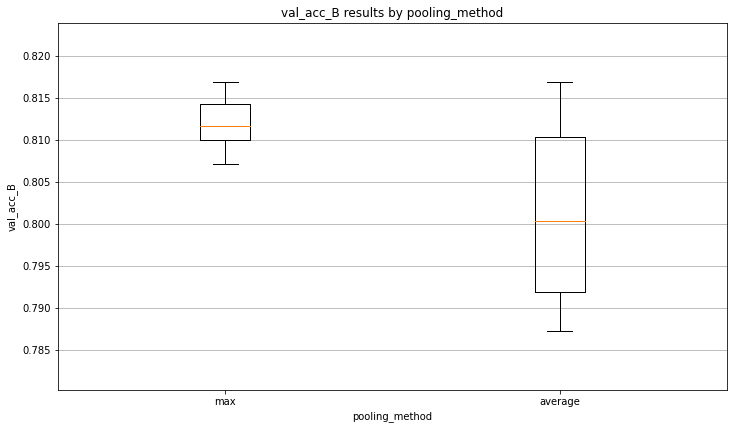

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['pooling_method'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['pooling_method'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [(300,100),**(200,75)**], [**(400,75)**,(200,100)]
* cnn_activation: ['tanh', **'relu'**]
* pooling_method: 'max'
* spatial_dropout: [0.3,**0.5**]
* dense_dropout:[**0.5**]


* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'

# Experimentos con el batch_size

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['AG'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import combinations
from itertools import product

dense_layers_sizes = [(300,100),
                      (300,75)]                                 

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175],
              'conv_layers_activation':['relu'],
              'pooling_method':['max'],
              'spatial_dropout':[0.3],
              'dense_dropout':[0.3]}  

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

4 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[256,512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


6 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


24 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/AG/experiments_5.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/CNN/AG/experiments_5.df
SCANNING SEARCH SPACE

24 configurations will be evaluated.
1  - conf_ID: GqOuIUuu   ****  --  train_acc_1 = 0.791,  val_acc_1 = 0.807    --  train_acc_2 = 0.803,  val_acc_2 = 0.81    
2  - conf_ID: kCyRhpbC   ****  --  train_acc_1 = 0.834,  val_acc_1 = 0.806    --  train_acc_2 = 0.835,  val_acc_2 = 0.811   
3  - conf_ID: VxPoVnAf   ****  --  train_acc_1 = 0.833,  val_acc_1 = 0.81     --  train_acc_2 = 0.859,  val_acc_2 = 0.814   
4  - conf_ID: BixFoeNj   ****  --  train_acc_1 = 0.911,  val_acc_1 = 0.798    --  train_acc_2 = 0.821,  val_acc_2 = 0.811   
5  - conf_ID: aHYZYKBs   ****  --  train_acc_1 = 0.799,  val_acc_1 = 0.802    --  train_acc_2 = 0.857,  val_acc_2 = 0.816   
6  - conf_ID: vcWAcXbU   ****  --  train_acc_1 = 0.805,  val_acc_1 = 0.81     --  train_acc_2 = 0.801,  val_acc_2 = 0.817   
7  - conf_ID: cjYntPzx   ****  --  train_acc_1 = 0.828,  val_acc_1 = 0.81     --  train_acc_2 = 0.827,  val_acc_2 = 0.815   
8  - conf_ID: qRUTB

## Resultados

In [11]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/AG/experiments_5.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(24, 19)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

In [ ]:
params_dict = {'batch_size':[256,512,1024]}

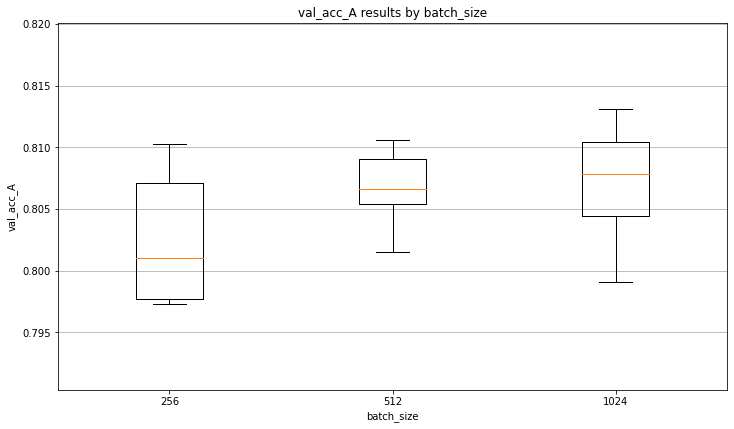

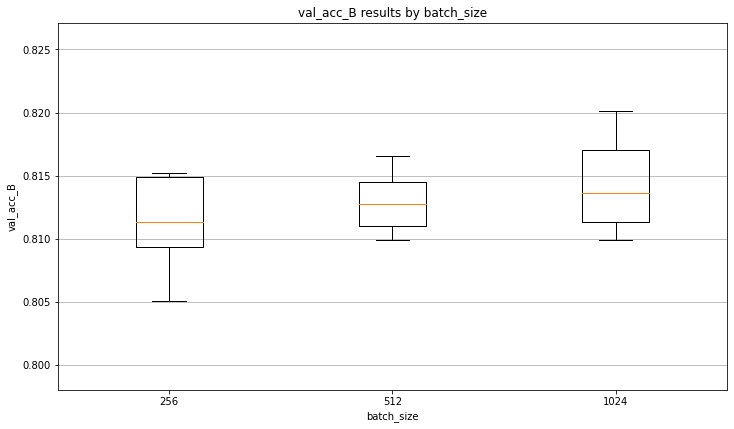

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [(300,100),**(200,75)**], [**(400,75)**,(200,100)]
* cnn_activation: ['tanh', **'relu'**]
* pooling_method: 'max'
* spatial_dropout: [0.3,**0.5**]
* dense_dropout:[**0.5**]


* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'
* batch_size: [256,**1024**]

# Experimento final

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['AG'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import combinations
from itertools import product

dense_layers_sizes = [(300,100),
                      (300,75)]                                 

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175],
              'conv_layers_activation':['relu'],
              'pooling_method':['max'],
              'spatial_dropout':[0.3],
              'dense_dropout':[0.3]}  

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

4 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


8 params combinations in the search_space.


In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=False,
                          backup_file='./Results/CNN/AG/experiments_6.df',
                          backup_freq=1,
                          save_history_files=True,
                          save_models_as_json=True,
                          save_weights=True)

## Resultados

In [13]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/AG/experiments_6f.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(8, 19)

In [14]:
search_results.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
6,YAsdTTEC,"(2, 3, 4)","(300, 75)",175,relu,max,0.3,0.3,adam-1e-4,1024,75,26,0.912600,0.810603,14,29,23,0.880966,0.819201
4,lUQlOGae,"(2, 3, 4)","(300, 100)",175,relu,max,0.3,0.3,adam-1e-4,1024,75,18,0.823466,0.810599,18,30,25,0.887401,0.820801
0,heguIhkD,"(1, 2, 3)","(300, 100)",175,relu,max,0.3,0.3,adam-1e-4,1024,75,27,0.858334,0.809201,18,34,28,0.853632,0.819001
3,AafqTJRJ,"(1, 2, 3)","(300, 75)",175,relu,max,0.3,0.3,rmsprop-1e-3,1024,75,22,0.801768,0.807002,22,46,26,0.801700,0.818401
2,QGsgmPVe,"(1, 2, 3)","(300, 75)",175,relu,max,0.3,0.3,adam-1e-4,1024,75,26,0.837134,0.806399,20,45,26,0.858133,0.815603


In [15]:
search_results.sort_values(by='val_acc_B', ascending=False).head()

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
4,lUQlOGae,"(2, 3, 4)","(300, 100)",175,relu,max,0.3,0.3,adam-1e-4,1024,75,18,0.823466,0.810599,18,30,25,0.887401,0.820801
1,lYkXiQZd,"(1, 2, 3)","(300, 100)",175,relu,max,0.3,0.3,rmsprop-1e-3,1024,75,34,0.818900,0.804798,19,35,28,0.824972,0.819603
5,DztMWiJK,"(2, 3, 4)","(300, 100)",175,relu,max,0.3,0.3,rmsprop-1e-3,1024,75,25,0.822436,0.805405,15,38,31,0.795103,0.819201
6,YAsdTTEC,"(2, 3, 4)","(300, 75)",175,relu,max,0.3,0.3,adam-1e-4,1024,75,26,0.912600,0.810603,14,29,23,0.880966,0.819201
0,heguIhkD,"(1, 2, 3)","(300, 100)",175,relu,max,0.3,0.3,adam-1e-4,1024,75,27,0.858334,0.809201,18,34,28,0.853632,0.819001
